In [11]:
from synapse import Action, Cubic
from typing import List, Tuple
import numpy as np
import random

def sample_cubics(n: int, delta: float) -> Tuple[float, List[Cubic]]:
    num_cubics = n
    start_position = random.uniform(0, 1)
    current_position = start_position
    current_cubics = []
    for _ in range(num_cubics):
        permissible_range = [-current_position, 1-current_position]
        def generate_cubic():
            return Cubic(
                m=random.uniform(-delta, delta),
                n=random.uniform(-delta, delta),
                a=random.uniform(*permissible_range),
            )
        
        cubic = generate_cubic()
        results = cubic(np.linspace(0, 1, 10))
        min_results = np.min(results)
        max_results = np.max(results)

        while min_results + current_position < 0 or max_results + current_position > 1:
            cubic = generate_cubic()
            results = cubic(np.linspace(0, 1, 10))
            min_results = np.min(results)
            max_results = np.max(results)

        current_position += cubic(1)
        current_cubics.append(cubic)
    
    return start_position, current_cubics

In [12]:
def cubics_to_points(x_start: float, y_start: float, x_cubics: List[Cubic], y_cubics: List[Cubic], fps=2, x_points: np.ndarray=np.linspace(0, 1, 400)) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    previous_last = (x_start, y_start)

    all_poly_x = []
    all_poly_y = []

    for (xc, yc) in zip(x_cubics, y_cubics):
        x_dense = x_points
        y_cubic_of_xcoord = xc(x_dense)
        y_cubic_of_ycoord = yc(x_dense)

        all_poly_x.extend(y_cubic_of_xcoord + previous_last[0])
        all_poly_y.extend(y_cubic_of_ycoord + previous_last[1])

        previous_last = (xc(1) + previous_last[0],
                        yc(1) + previous_last[1])

    # t = list(range(len(all_poly_x)))
    t = np.arange(0, len(all_poly_x)/fps, 1/fps)

    return t, np.array(all_poly_x), np.array(all_poly_y)

(0.0, 480.0)

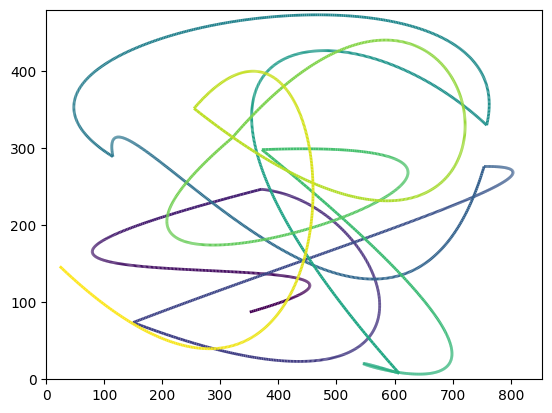

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from io import BytesIO
from PIL import Image

screen_size = (854, 480)
t = np.array(t)
x = np.array(all_poly_x) * screen_size[0]
y = np.array(all_poly_y) * screen_size[1]
norm = plt.Normalize(t.min(), t.max())
colors = cm.viridis(norm(t))

# Build segments between consecutive points
pts = np.stack([x, y], axis=1)
segs = np.concatenate([pts[:-1,None], pts[1:,None]], axis=1)

# Create a LineCollection, one segment per time step
lc = LineCollection(segs, colors=colors[:-1], linewidth=2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.set_xlim(0, screen_size[0])
ax.set_ylim(0, screen_size[1])

# ax.set_aspect('equal', 'box')
# ax.axis('off')                      # <-- turn off axes
# fig.subplots_adjust(left=0, right=1, top=1, bottom=0)  # no margins

# # Render to an in-memory PNG
# buf = BytesIO()
# fig.savefig(buf, format='png', dpi=100, bbox_inches='tight', pad_inches=0)
# plt.close(fig)
# buf.seek(0)

# # # Load into Pillow
# img = Image.open(buf)

# # And if you want a NumPy array:
# img_arr = np.array(img)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image, ImageDraw

from synapse.video_loader.video import smart_resize

def generate_image_from_segments(t: np.ndarray, x: np.ndarray, y: np.ndarray, screen_size: tuple[float, float]) -> Image:
    x = x * screen_size[0]
    y = y * screen_size[1]
    norm = plt.Normalize(t.min(), t.max())
    colors = cm.viridis(norm(t))

    # pick a colormap and normalize t to [0,1]
    norm = (t - t.min()) / (t.max() - t.min())
    colors = (cm.viridis(norm)[:, :3] * 255).astype(np.uint8)

    # make a blank RGBA image
    scale_factor = 8
    upsampled = (screen_size[0] * scale_factor, screen_size[1] * scale_factor)
    img = Image.new("RGBA", upsampled, (255,255,255,255))
    draw = ImageDraw.Draw(img)

    for i in range(len(x)-1):
        p0 = (x[i]*scale_factor,   y[i]*scale_factor)
        p1 = (x[i+1]*scale_factor, y[i+1]*scale_factor)
        draw.line([p0, p1], fill=tuple(colors[i]), width=int(4.3*scale_factor))

    img_small = img.resize(screen_size, Image.LANCZOS)
    return img_small

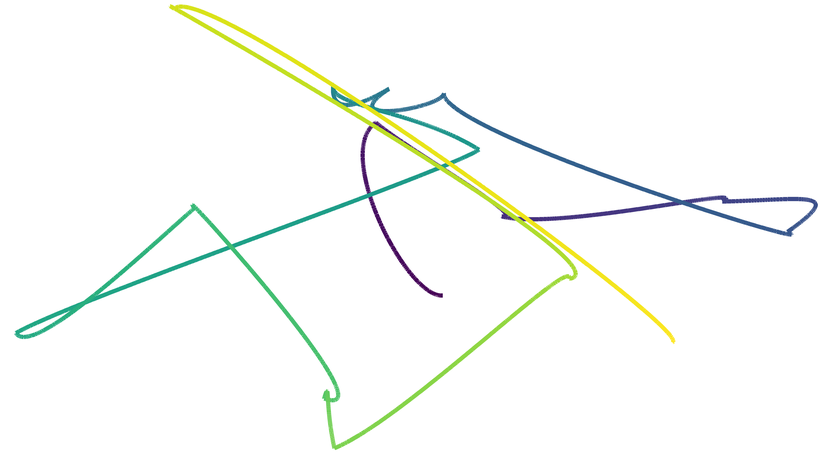

In [77]:
SCREEN_SIZE = smart_resize(854, 480, factor=28, min_pixels=0, max_pixels=854*480)
n_segments = 15
delta = 0.3
(x_start, x_cubics), (y_start, y_cubics) = sample_cubics(n_segments, delta), sample_cubics(n_segments, delta)
t, all_poly_x, all_poly_y = cubics_to_points(x_start, y_start, x_cubics, y_cubics)
img = generate_image_from_segments(t, all_poly_x, all_poly_y, SCREEN_SIZE)
img

In [578]:
overlay = Image.open('../../assets/default.png').convert('RGBA')

def create_video_array(x_start: float, y_start: float, x_cubics: List[Cubic], y_cubics: List[Cubic]):
    ts, all_poly_x, all_poly_y = cubics_to_points(x_start, y_start, x_cubics, y_cubics, fps=4, x_points=np.array([0, 0.5]))
    imgs = []
    timestamps = []
    for i, (time, x, y) in enumerate(zip(ts, all_poly_x, all_poly_y)):
        new_img = img.copy()
        new_img.paste(overlay, (int(x * SCREEN_SIZE[0]), int(y * SCREEN_SIZE[1])), overlay)
        imgs.append(new_img)
        timestamps.append(time)

    img_array = np.array([imgs[0]]+imgs)[:, :, :, :3]
    time_array = np.array(timestamps)

    return time_array, img_array

In [579]:
times, imgs = create_video_array(x_start, y_start, x_cubics, y_cubics)

In [599]:
i = -1

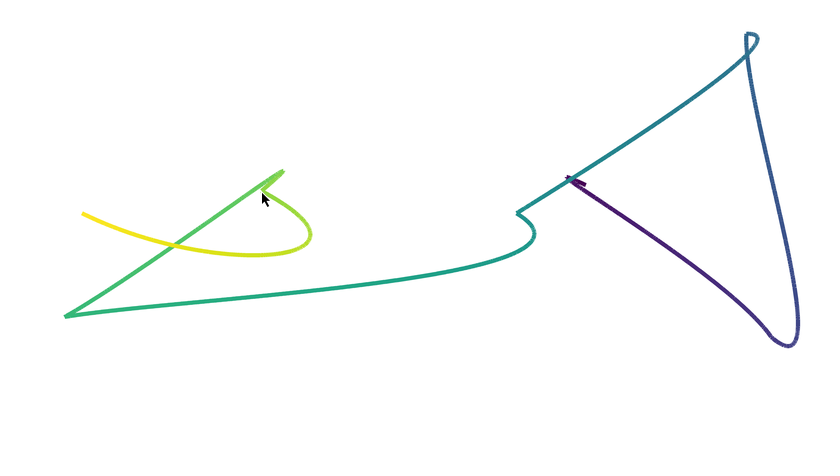

In [611]:
i += 1
Image.fromarray(imgs[i])

In [447]:
x_cubics

[Cubic(m=0.4192874759490953, n=0.043754777575124915, a=0.1314977533909334),
 Cubic(m=-0.031061095279514395, n=-0.1350039980861657, a=-0.7150942386908548),
 Cubic(m=0.22668089638922895, n=0.24358940567849074, a=0.020048000748853045),
 Cubic(m=-0.3772101134595526, n=-0.14635569645392865, a=0.5278685190351984),
 Cubic(m=-0.03949039273288457, n=-0.37997255998874846, a=0.15991315911632742),
 Cubic(m=0.4552837714803063, n=0.40395327782676826, a=0.027904891442541713)]

(840, 476)

In [95]:
from synapse.video_loader.read_frames import fetch_frames_from_zarr

In [102]:
i = -1

In [113]:
i += 1
frames = await fetch_frames_from_zarr(f"gs://induction-labs/jonathan/synth/cursor_follow_v0/sample_{i}.zarr", (0, 2))
Image.fromarray(frames[0].transpose(1, 2, 0))

ValueError: NOT_FOUND: Error opening "zarr3" driver: Metadata at gs://induction-labs/jonathan/synth/cursor_follow_v0/sample_10.zarr/zarr.json does not exist [tensorstore_spec='{\"context\":{\"cache_pool\":{},\"data_copy_concurrency\":{},\"gcs_request_concurrency\":{},\"gcs_request_retries\":{},\"gcs_user_project\":{}},\"driver\":\"zarr3\",\"kvstore\":{\"bucket\":\"induction-labs\",\"driver\":\"gcs\",\"path\":\"jonathan/synth/cursor_follow_v0/sample_10.zarr/\"}}'] [source locations='tensorstore/driver/kvs_backed_chunk_driver.cc:1320\ntensorstore/driver/driver.cc:116']

In [1]:
import run

In [2]:
time, imgs, x_cubics, y_cubics = run.video

In [3]:
from synapse.video_loader.typess import FramesMetadata, VideoResolution, VideoMetadata, StreamMetadata
from synapse.video_loader.video import smart_resize
from fractions import Fraction

SCREEN_SIZE = smart_resize(854, 480, factor=28, min_pixels=0, max_pixels=854 * 480)
output_meta = FramesMetadata(
    fps=Fraction(4),
    total_frames=imgs.shape[0],
    resolution=VideoResolution(
        width=SCREEN_SIZE[0],
        height=SCREEN_SIZE[1],
    )
)
input_meta = VideoMetadata(
    start_pts=0,
    duration=imgs.shape[0],
    time_base=Fraction(1, 4),
    **output_meta.model_dump()
)
stream_metadata = StreamMetadata(
    input_video=input_meta,
    output_video=output_meta,
    output_frames_per_chunk=imgs.shape[0]
)

In [4]:
import tensorstore as ts
from synapse.video_loader.zarr_utils import (
    ZarrArrayAttributes,
    append_batch,
    create_zarr_array,
)

shape = (output_meta.total_frames, 3, output_meta.resolution.height, output_meta.resolution.width)
zarr_array = await create_zarr_array(
            ZarrArrayAttributes(
                chunk_shape=shape,
                shape=shape,
                dtype=ts.uint8,
                path="gs://induction-labs/jonathan/synth/testing2.zarr",
                metadata={
                    "stream": stream_metadata.model_dump(),
                },
            ),
        )

I0627 14:37:48.990043 1172208 google_auth_provider.cc:149] Using credentials at /Users/jonathan/.config/gcloud/application_default_credentials.json
I0627 14:37:48.990379 1172208 google_auth_provider.cc:156] Using OAuth2 AuthProvider


In [5]:
imgs.shape

(13, 476, 840, 3)

In [ ]:
import torch
imgs_zarr_trans = torch.from_numpy(imgs).permute(0, 3, 1, 2)

await append_batch(zarr_array, imgs_zarr_trans, 0)

In [8]:
imgs_zarr_trans.shape

torch.Size([13, 3, 476, 840])

In [10]:
13*3*476*840

15593760

In [7]:
imgs.shape

(13, 476, 840, 3)